# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Useful Functions

In [2]:
# Plot Time Series Graph
def plot_time_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)  

# To generate trend
def trend(time, slope=0):
  return time * slope

# To generate Seasonal Pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
# To generate seasonality data
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

# To generate noise
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

# Trend & Seasonality

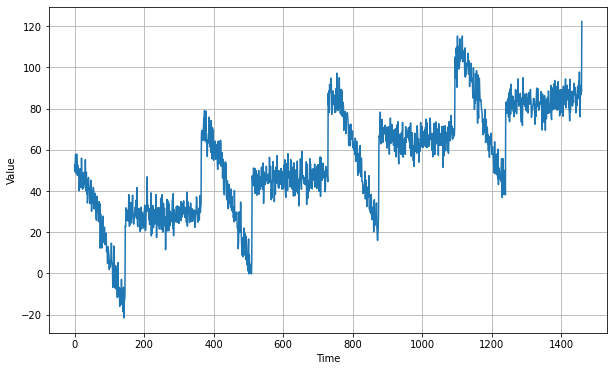

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level=noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# 1- Naive Forecast

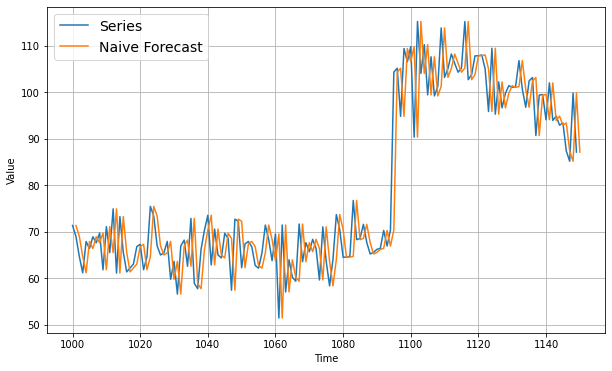

In [4]:
split_time = 1000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = series[:split_time]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1: -1]

plt.figure(figsize=(10,6))
plot_time_series(time_valid, x_valid, start=0, end=150, label='Series')
plot_time_series(time_valid, naive_forecast, start=1, end=151, label='Naive Forecast')
plt.show()

In [5]:
# Mean Absolute Error
naive_forecast_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid,
                                                          y_pred=naive_forecast)
naive_forecast_mae.numpy()

5.937908515321673

# 2- Moving Average

## First Approach

In [6]:
# First Approach (Work slowly due to for loop)
def moving_average_forecast(series, window_size):
  forecast = []
  series_length = len(series)
  print(f'Series Length: {series_length}, Window Size: {window_size}')

  for time in range(series_length - window_size):
    forecast.append(series[time:time+window_size].mean())

  return np.array(forecast)

In [7]:
window_size = 30
moving_avg = moving_average_forecast(series, window_size=window_size)[split_time-30 :]


Series Length: 1461, Window Size: 30


In [10]:
print(len(moving_avg))
print(moving_avg[:10])

461
[63.04546593 63.26681317 63.54423121 63.42419519 63.43560223 63.63711952
 64.02872772 64.2647332  64.78631306 65.23727352]


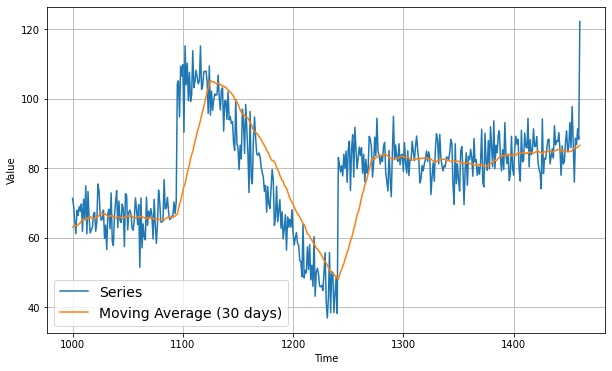

In [8]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid, label='Series')
plot_time_series(time_valid, moving_avg, label='Moving Average (30 days)')
plt.show()

## Second Approach

In [19]:
# ROUGH WORK (To Understand above function)
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
print('a: ',a)
a_cumsum = np.cumsum(a)
print('a cumsum: ', a_cumsum)

w_size = 3
print('\na cumsum[3:] --> ', a_cumsum[w_size:])
print('a cumsum[:-3] --> ',a_cumsum[:-w_size])

a_cumsum[w_size:] = a_cumsum[w_size:] - a_cumsum[:-w_size]
print('a cumsum[3:]: (difference of above two) --> ',a_cumsum)

print(a_cumsum[w_size -1: -1])
print(a_cumsum[w_size -1: -1]/w_size)

a:  [ 1  2  3  4  5  6  7  8  9 10 11]
a cumsum:  [ 1  3  6 10 15 21 28 36 45 55 66]

a cumsum[3:] -->  [10 15 21 28 36 45 55 66]
a cumsum[:-3] -->  [ 1  3  6 10 15 21 28 36]
a cumsum[3:]: (difference of above two) -->  [ 1  3  6  9 12 15 18 21 24 27 30]
[ 6  9 12 15 18 21 24 27]
[2. 3. 4. 5. 6. 7. 8. 9.]


In [20]:
# Rough Work
mv_a = []
for t in range(len(a)-w_size):
  mv_a.append(a[t : t+w_size].mean())
print(mv_a)

[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


In [11]:
# Second Approach (Work Faster)
def moving_average_forecast(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size -1 : -1] / window_size

In [13]:
window_size = 30
moving_avg = moving_average_forecast(series, window_size=window_size)[split_time-30 :]

In [14]:
print(len(moving_avg))
print(moving_avg[:10])

461
[63.04546593 63.26681317 63.54423121 63.42419519 63.43560223 63.63711952
 64.02872772 64.2647332  64.78631306 65.23727352]


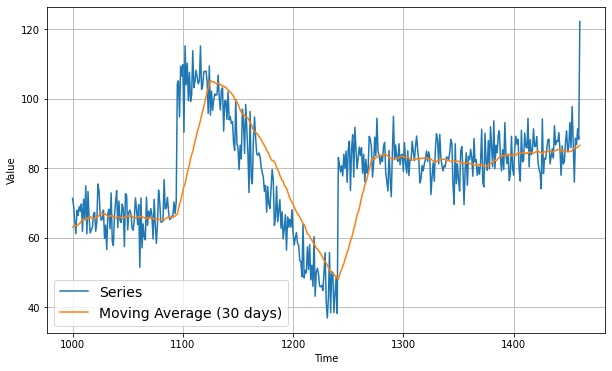

In [15]:
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid, label='Series')
plot_time_series(time_valid, moving_avg, label='Moving Average (30 days)')
plt.show()

In [16]:
# Calculate Mean Absolute Error
moving_avg_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid,
                                                      y_pred=moving_avg)
moving_avg_mae.numpy()

7.1424185706207854

## 2.1- Differencing

NOTE:
* Moving average does not catch trend and seasonality
* It can be remove by using differencing
* Since seasonality period 365 days, it can be remove

In [35]:
len(series)

1461

In [21]:
diff_time = time[365:]
diff_series = (series[365:] - series[:-365])

In [24]:
len(diff_series), diff_series

(1096, array([13.76032688, 20.06178391, 15.07451931, ..., 24.43903434,
        17.95270637, 17.96130298]))

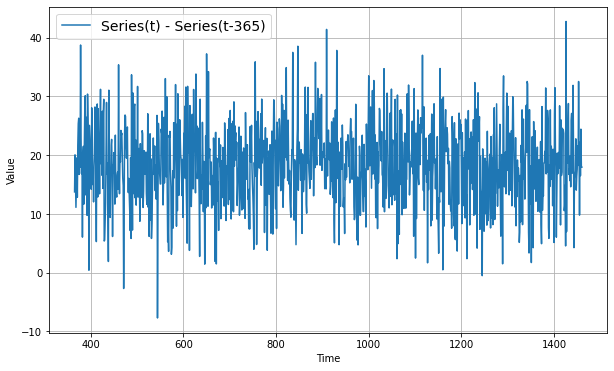

In [22]:
plt.figure(figsize=(10, 6))
plot_time_series(diff_time, diff_series, label='Series(t) - Series(t-365)')
plt.show()

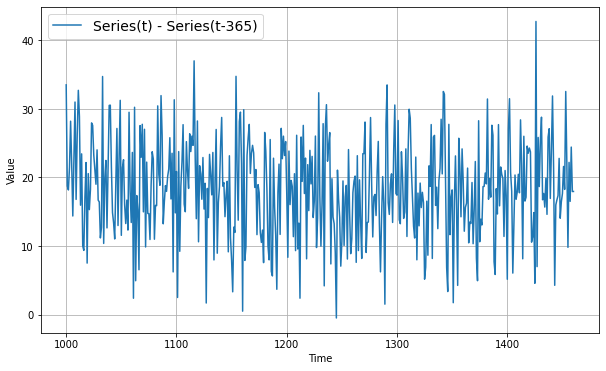

In [ ]:
# For validation period
plt.figure(figsize=(10, 6))
plot_time_series(time_valid, diff_series[split_time-365:], label='Series(t) - Series(t-365)')
plt.show()

## 2.2 Calculate moving avg for differencing

* Seasonality has been removed now.
* Now calculate moving average for difference

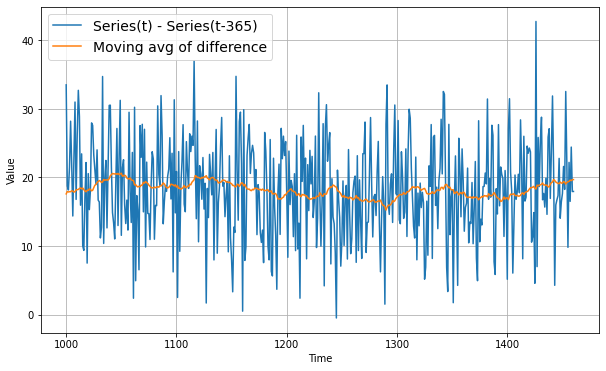

In [26]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_time_series(time_valid, diff_series[split_time - 365: ], label='Series(t) - Series(t-365)')
plot_time_series(time_valid, diff_moving_avg, label='Moving avg of difference')
plt.show()

## 2.3- Adding back trend and seasonality

* For trend and seasonality, adding past values from t-365

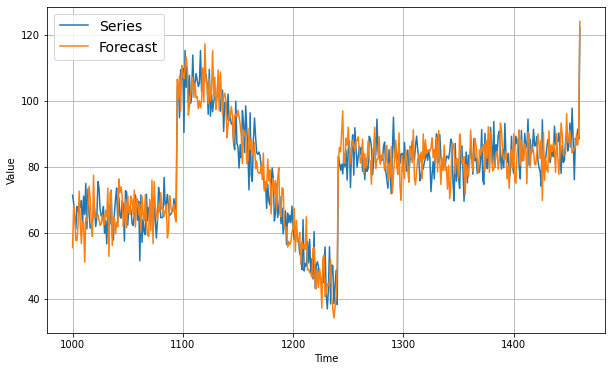

In [27]:
diff_moving_avg_plus_past_val = diff_moving_avg + series[split_time - 365: -365]

plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid, label='Series')
plot_time_series(time_valid, diff_moving_avg_plus_past_val, label='Forecast')
plt.show()

In [29]:
diff_moving_avg_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid,
                                                           y_pred=diff_moving_avg_plus_past_val)
diff_moving_avg_mae.numpy()

5.839310562995895

## 2.4- Improving result by removing some noise

* Improving result by removing noise

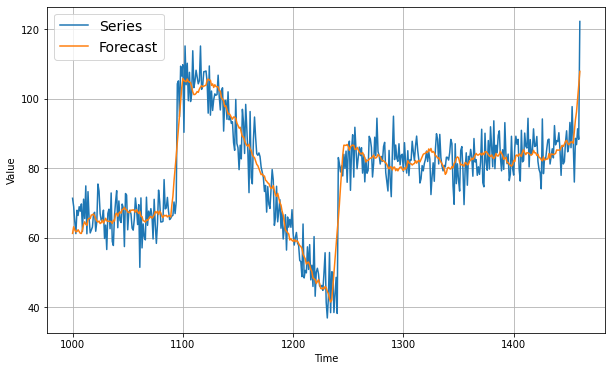

In [32]:
diff_moving_avg_smooth_past = moving_average_forecast(series[split_time -370 : -359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_time_series(time_valid, x_valid, label='Series')
plot_time_series(time_valid, diff_moving_avg_smooth_past, label='Forecast')
plt.show()

In [34]:
diff_moving_avg_smooth_past_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid,
                                                                       y_pred=diff_moving_avg_smooth_past)

diff_moving_avg_smooth_past_mae.numpy()

4.566859958970771